# Generate Data

## DPO Data

In [1]:
import json
from pathlib import Path

train_data_path = Path("data/real/cleaned_ds_train.json")
validation_data_path = Path("data/real/cleaned_ds_validation.json")

with open(train_data_path, "r") as f:
    train_data = json.load(f)
    print(f"There are {len(train_data)} training samples")

with open(validation_data_path, "r") as f:
    validation_data = json.load(f)
    print(f"There are {len(validation_data)} validation samples")

def ticker_data_map(data):
    import re
    ticker_map = {}
    for item in data:
        x = item['text']
        x = re.sub(r'https?://\S+', '', x)
        stock_ticket = re.search(r'\$([A-Z]+)', x)
        if stock_ticket:
            ticker = stock_ticket.group(1)
            if ticker not in ticker_map:
                ticker_map[ticker] = []
            ticker_map[ticker].append(item)
    return ticker_map

train_ticker_map = ticker_data_map(train_data)
validation_ticker_map = ticker_data_map(validation_data)

print(f"There are {len(train_ticker_map)} training tickers")
print(f"There are {len(validation_ticker_map)} validation tickers")

There are 9543 training samples
There are 2388 validation samples
There are 921 training tickers
There are 302 validation tickers


In [2]:
prompt_template = Path("prompt_templates/dpo.txt").read_text()
sentiment_map = {0: "bearish (0)", 1: "bullish (1)", 2: "neutral (2)"}

### Load Synthetic Data

In [3]:
from pathlib import Path
import json
import re

synthetic_data_path = Path("data/synthetic/qwen2.5-instruct_original_prompt=zero-shot_bg_train-time-info_v2.json")

with open(synthetic_data_path, "r") as f:
    synthetic_data = json.load(f)

def process_sentiment(sentiment):
    lowered = sentiment.lower()
    if "bullish" in lowered or "1" in lowered:
        return 1
    elif "bearish" in lowered or "0" in lowered:
        return 0
    else:
        return 2

synthetic_ticker_sentiment_map = {} # ticker -> sentiment -> headline
for item in synthetic_data:
    headline = item["headline"]
    sentiment = item["sentiment"]
    processed_sentiment = process_sentiment(sentiment)
    ticker = re.search(r'\$([A-Z]+)', headline)
    if ticker:
        ticker = ticker.group(1)
        if ticker not in synthetic_ticker_sentiment_map:
            synthetic_ticker_sentiment_map[ticker] = {}
        synthetic_ticker_sentiment_map[ticker][processed_sentiment] = item

synthetic_ticker_sentiment_map['NVDA']

{1: {'headline': '$NVDA bullish on its recent earnings report',
  'sentiment': 'Bullish'},
 2: {'headline': "$NVDA - Equinix's Q3 revenue beats expectations, no action from market.",
  'sentiment': 'neutral'},
 0: {'headline': '$NVDA : $NVDA in下げ auf Russell 2000 abrechnen',
  'sentiment': '0'}}

In [5]:
def generate_dpo_messages(input_id, prompt, chosen_targets, rejected_targets):
    chosen_messages = [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": chosen_targets}
    ]
    rejected_messages = [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": rejected_targets}
    ]

    return {"id": input_id, "prompt": prompt, "chosen": chosen_messages, "rejected": rejected_messages}

In [ ]:
dpo_data_list = []

ticker_counter = 0
for ticker, data in train_ticker_map.items():
    if ticker not in synthetic_ticker_sentiment_map:
        continue
    for i, item in enumerate(data):
        target = item["text"]
        label = item["label"]
        if label not in synthetic_ticker_sentiment_map[ticker]:
            continue
        input_prompt = prompt_template.replace("{stock_ticker}", f"${ticker}").replace("{sentiment}", sentiment_map[label])
        json_target = json.dumps({"headline": target, "sentiment": label})
        synthetic_target = json.dumps(synthetic_ticker_sentiment_map[ticker][label])
        dpo_data = generate_dpo_messages(f"data_synthesis_dpo_ticker_{ticker_counter}_{i}", 
                                         input_prompt, json_target, synthetic_target)
        dpo_data_list.append(dpo_data)
    ticker_counter += 1
print(f"Total DPO data: {len(dpo_data_list)}")
dpo_data_list[1]

### Upload to Hugging Face Hub

In [ ]:
from datasets import Dataset, DatasetDict
from huggingface_hub import HfApi

# Convert the list of dictionaries to a Dataset
dpo_dataset = Dataset.from_list(dpo_data_list)

# Create a DatasetDict if you have multiple splits (e.g., train, validation)
dataset_dict = DatasetDict({"train": dpo_dataset})

# Push the dataset to Hugging Face Hub
import os
os.environ["HF_TOKEN"] = ""
dataset_dict.push_to_hub("ArthurChen189/financial_news_sentiment_analysis_dpo", private=True)

## SFT Data

In [ ]:
prompt_template = Path("prompt_templates/sft.txt").read_text()


def generate_sft_data(input_id, prompt, target):
    messages = [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": target}
    ]
    return {"id": input_id, "messages": messages}

sft_data_list = []

ticker_counter = 0
for ticker, data in train_ticker_map.items():
    for i, item in enumerate(data):
        target = item["text"]
        label = item["label"]
        # input_prompt = prompt_template.format(stock_ticker=f"${ticker}", sentiment=sentiment_map[label])
        input_prompt = prompt_template.replace("{stock_ticker}", f"${ticker}").replace("{sentiment}", sentiment_map[label])
        json_target = json.dumps({"headline": target, "sentiment": label})
        sft_data = generate_sft_data(f"data_synthesis_sft_ticker_{ticker_counter}_{i}", input_prompt, json_target)
        sft_data_list.append(sft_data)
    ticker_counter += 1

sft_data_list[1]

### Upload to Hugging Face Hub

In [ ]:
from datasets import Dataset, DatasetDict
from huggingface_hub import HfApi

# Convert the list of dictionaries to a Dataset
sft_dataset = Dataset.from_list(sft_data_list)

# Create a DatasetDict if you have multiple splits (e.g., train, validation)
dataset_dict = DatasetDict({"train": sft_dataset})

# Push the dataset to Hugging Face Hub
import os
os.environ["HF_TOKEN"] = ""
dataset_dict.push_to_hub("ArthurChen189/financial_news_sentiment_analysis_sft", private=True)

# Test results

In [16]:
# load data
import json
real_test_data = json.load(open("data/real/cleaned_ds_validation.json"))

original_synthetic_data = json.load(open("data/synthetic/qwen2.5-instruct_original_prompt=zero-shot_bg_test-time-info_v2.json"))
sft_synthetic_data = json.load(open("data/synthetic/qwen2.5-instruct_sft_prompt=zero-shot_bg_test-time-info_v2.json"))
dpo_synthetic_data = json.load(open("data/synthetic/qwen2.5-instruct_dpo_prompt=zero-shot_bg_test-time-info_v2.json"))

# --- preprocess sentiment ---
def preprocess_data(data, x_key, y_key):
    def process_sentiment(sentiment):
        lowered = str(sentiment).lower()
        if "bullish" in lowered or "1" in lowered:
            return 1
        elif "bearish" in lowered or "0" in lowered:
            return 0
        else:
            return 2
    inputs = []
    labels = []
    for item in data:
        inputs.append(str(item[x_key]))
        labels.append(process_sentiment(item[y_key]))
    return inputs, labels

real_test_data_inputs, real_test_data_labels = preprocess_data(real_test_data, 'text', 'label')
real_train_data_inputs, real_train_data_labels = preprocess_data(train_data, 'text', 'label')
original_synthetic_data_inputs, original_synthetic_data_labels = preprocess_data(original_synthetic_data, 'headline', 'sentiment')
sft_synthetic_data_inputs, sft_synthetic_data_labels = preprocess_data(sft_synthetic_data, 'headline', 'sentiment')
dpo_synthetic_data_inputs, dpo_synthetic_data_labels = preprocess_data(dpo_synthetic_data, 'headline', 'sentiment')

error_index = 981
sft_synthetic_data_inputs.pop(error_index)
sft_synthetic_data_labels.pop(error_index)

# make sure the number of synthetic data is the same
dpo_synthetic_data_inputs.pop(0) 
dpo_synthetic_data_labels.pop(0)

original_synthetic_data_inputs.pop(0)
original_synthetic_data_labels.pop(0)

# sample real train data
import random
random.seed(42)  # Set seed for reproducibility

# Get the size of synthetic datasets
synthetic_data_size = len(dpo_synthetic_data_inputs)

# Sample from real_train_data to match the synthetic data size
sampled_indices = random.sample(range(len(real_train_data_inputs)), synthetic_data_size)
real_train_data_inputs = [real_train_data_inputs[i] for i in sampled_indices]
real_train_data_labels = [real_train_data_labels[i] for i in sampled_indices]

print(f"There are {len(real_test_data_inputs)} real test data")
print(f"There are {len(real_train_data_inputs)} sampled real train data")
print(f"There are {len(original_synthetic_data_inputs)} original synthetic data")
print(f"There are {len(sft_synthetic_data_inputs)} sft synthetic data")
print(f"There are {len(dpo_synthetic_data_inputs)} dpo synthetic data")


There are 2388 real test data
There are 1106 sampled real train data
There are 1106 original synthetic data
There are 1106 sft synthetic data
There are 1106 dpo synthetic data


In [17]:
from sentence_transformers import SentenceTransformer
from tqdm import auto as tqdm
powerful_model_path = 'intfloat/e5-small-v2'
sentence_model = SentenceTransformer(powerful_model_path)

emb_real = sentence_model.encode(real_test_data_inputs)
emb_real_train = sentence_model.encode(real_train_data_inputs)
original_emb_synth = sentence_model.encode(original_synthetic_data_inputs)
sft_emb_synth = sentence_model.encode(sft_synthetic_data_inputs)
dpo_emb_synth = sentence_model.encode(dpo_synthetic_data_inputs)

In [20]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold

# Set seed for reproducibility
SEED = 42

params = {
    'objective': 'multi:softmax', # Change to multiclass classification
    'eval_metric': 'mlogloss',    # Change metric for multiclass
    'num_class': 3,               # Specify number of classes (0,1,2)
    'seed': SEED                  # Set seed for XGBoost
}

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
dtest = xgb.DMatrix(emb_real, label=real_test_data_labels)

# Train on real train data
# Train on real train data
real_training_results = []
dtrain = xgb.DMatrix(emb_real_train, label=real_train_data_labels)
for i, (train_index, val_index) in enumerate(kf.split(emb_real_train)):
    dtrain = xgb.DMatrix(emb_real_train[train_index], label=np.array(real_train_data_labels)[train_index])
    dval = xgb.DMatrix(emb_real_train[val_index], label=np.array(real_train_data_labels)[val_index])
    m = xgb.train(
        params, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dval, 'validation')],
        verbose_eval=False,
    )
    real_training_results.append(dict(
        fold=i,
        dataset='real train data',
        model=m,
        train_acc=np.mean(m.predict(dtrain)==np.array(real_train_data_labels)[train_index]),
        val_acc=np.mean(m.predict(dval)==np.array(real_train_data_labels)[val_index]),
        test_acc=np.mean(m.predict(dtest)==np.array(real_test_data_labels)),
    ))


# Train on original synthetic data
original_training_results = []
dtrain = xgb.DMatrix(original_emb_synth, label=original_synthetic_data_labels)
for i, (train_index, val_index) in enumerate(kf.split(original_emb_synth)):
    dtrain = xgb.DMatrix(original_emb_synth[train_index], label=np.array(original_synthetic_data_labels)[train_index])
    dval = xgb.DMatrix(original_emb_synth[val_index], label=np.array(original_synthetic_data_labels)[val_index])
    m = xgb.train(
        params, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dval, 'validation')],
        verbose_eval=False,
    )
    original_training_results.append(dict(
        fold=i,
        dataset='baseline',
        model=m,
        train_acc=np.mean(m.predict(dtrain)==np.array(original_synthetic_data_labels)[train_index]),
        val_acc=np.mean(m.predict(dval)==np.array(original_synthetic_data_labels)[val_index]),
        test_acc=np.mean(m.predict(dtest)==np.array(real_test_data_labels)),
    ))

# Train on SFT synthetic data
sft_training_results = []
dtrain = xgb.DMatrix(sft_emb_synth, label=sft_synthetic_data_labels)
for i, (train_index, val_index) in enumerate(kf.split(sft_emb_synth)):
    dtrain = xgb.DMatrix(sft_emb_synth[train_index], label=np.array(sft_synthetic_data_labels)[train_index])
    dval = xgb.DMatrix(sft_emb_synth[val_index], label=np.array(sft_synthetic_data_labels)[val_index])
    m = xgb.train(
        params, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dval, 'validation')],
        verbose_eval=False,
    )
    sft_training_results.append(dict(
        fold=i,
        dataset='sft',
        model=m,
        train_acc=np.mean(m.predict(dtrain)==np.array(sft_synthetic_data_labels)[train_index]),
        val_acc=np.mean(m.predict(dval)==np.array(sft_synthetic_data_labels)[val_index]),
        test_acc=np.mean(m.predict(dtest)==np.array(real_test_data_labels)),
    ))

# Train on DPO synthetic data
dpo_training_results = []
dtrain = xgb.DMatrix(dpo_emb_synth, label=dpo_synthetic_data_labels)
for i, (train_index, val_index) in enumerate(kf.split(dpo_emb_synth)):
    dtrain = xgb.DMatrix(dpo_emb_synth[train_index], label=np.array(dpo_synthetic_data_labels)[train_index])
    dval = xgb.DMatrix(dpo_emb_synth[val_index], label=np.array(dpo_synthetic_data_labels)[val_index])
    m = xgb.train(
        params, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dval, 'validation')],
        verbose_eval=False,
    )
    dpo_training_results.append(dict(
        fold=i,
        dataset='dpo',
        model=m,
        train_acc=np.mean(m.predict(dtrain)==np.array(dpo_synthetic_data_labels)[train_index]),
        val_acc=np.mean(m.predict(dval)==np.array(dpo_synthetic_data_labels)[val_index]),
        test_acc=np.mean(m.predict(dtest)==np.array(real_test_data_labels)),
    ))

# Combine results
training_results = sft_training_results + dpo_training_results + original_training_results + real_training_results

Summary Statistics:


,dataset,mean,std,min,max
0,baseline,0.559548,0.020937,0.529732,0.583333
1,dpo,0.430988,0.021068,0.400754,0.455611
2,real train data,0.764154,0.002537,0.760888,0.767588
3,sft,0.595980,0.010475,0.582077,0.610553


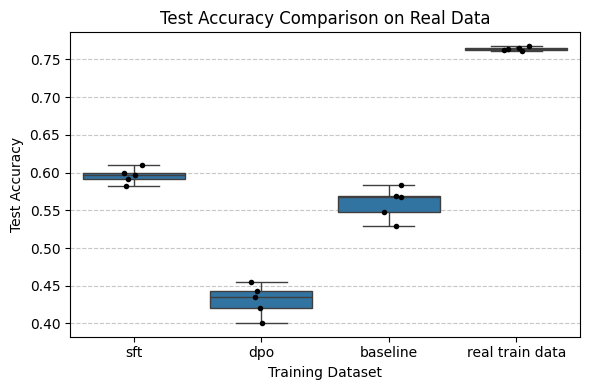

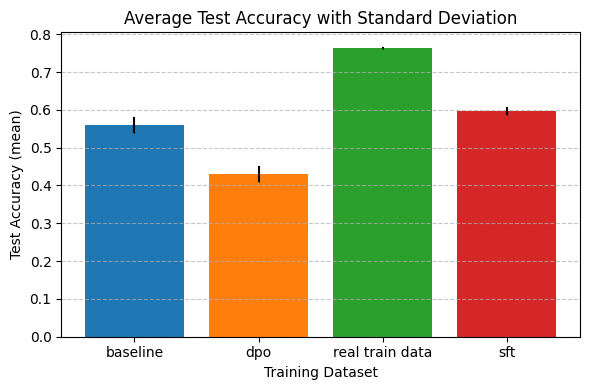

In [21]:
# Convert results to DataFrame for visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant metrics from training results
results_df = pd.DataFrame([
    {
        'dataset': result['dataset'],
        'fold': result['fold'],
        'test_accuracy': result['test_acc']
    }
    for result in training_results
])

# export results_df to csv
results_df.to_csv('results_df.csv', index=False)

# Calculate summary statistics
summary_df = results_df.groupby('dataset')['test_accuracy'].agg(['mean', 'std', 'min', 'max']).reset_index()
print("Summary Statistics:")
display(summary_df)

# Create visualization
plt.figure(figsize=(6, 4))
sns.boxplot(x='dataset', y='test_accuracy', data=results_df)
sns.stripplot(x='dataset', y='test_accuracy', data=results_df, color='black', size=4, jitter=True)

plt.title('Test Accuracy Comparison on Real Data')
plt.xlabel('Training Dataset')
plt.ylabel('Test Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('figures/test_accuracy_boxplot.png')
plt.show()

# Create a bar chart with error bars - fixed to avoid ValueError with yerr
plt.figure(figsize=(6, 4))
# Plot each bar individually to avoid the yerr shape mismatch
for i, row in summary_df.iterrows():
    plt.bar(i, row['mean'], yerr=row['std'], capsize=0.2)

plt.xticks(range(len(summary_df)), summary_df['dataset'])
plt.title('Average Test Accuracy with Standard Deviation')
plt.xlabel('Training Dataset')
plt.ylabel('Test Accuracy (mean)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('figures/test_accuracy_barchart.png')
plt.show()

In [25]:
# Convert to percentages and format to 2 decimal places
formatted_df = summary_df.copy()
formatted_df[['mean', 'std', 'min', 'max']] = formatted_df[['mean', 'std', 'min', 'max']] * 100
formatted_df[['mean', 'std', 'min', 'max']] = formatted_df[['mean', 'std', 'min', 'max']].round(2)
formatted_df

,dataset,mean,std,min,max
0,baseline,55.95,2.09,52.97,58.33
1,dpo,43.10,2.11,40.08,45.56
2,real train data,76.42,0.25,76.09,76.76
3,sft,59.60,1.05,58.21,61.06
